Problem 1(K-means)

In [240]:
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
import pandas as pd
import os
import math
from scipy.stats import multivariate_normal as mvn
from sklearn.metrics import confusion_matrix
import pickle
import copy
from numpy.linalg import inv
import re

1.a

In [2]:
n1 = int(500*0.2)
n2 = int(500*0.5)
n3 = int(500*0.3)
data1 = np.random.multivariate_normal([0,0], [[1,0],[0,1]], n1)
data2 = np.random.multivariate_normal([3,0], [[1,0],[0,1]], n2)
data3 = np.random.multivariate_normal([0,3], [[1,0],[0,1]], n3)
data = np.concatenate((data1,data2,data3))
np.random.shuffle(data)

In [3]:
class K_Means:
    def __init__(self, k=2,max_iter=20):
        self.k = k

        self.max_iter = max_iter

    def fit(self,data):

        self.centroids = {}
        self.object = []

        for i in range(self.k):
            self.centroids[i] = data[60-i]

        for i in range(self.max_iter):
            self.classifications = {}
            object_values = []
            for i in range(self.k):
                self.classifications[i] = []

            for featureset in data:
                distances = [np.linalg.norm(featureset-self.centroids[centroid])**2 for centroid in self.centroids]
                classification = distances.index(min(distances))
                self.classifications[classification].append(featureset)
                object_values.append(min(distances))
            self.object.append(sum(object_values))
            prev_centroids = dict(self.centroids)

            for classification in self.classifications:
                self.centroids[classification] = np.mean(self.classifications[classification],axis=0)

AxesSubplot(0.125,0.125;0.775x0.755)


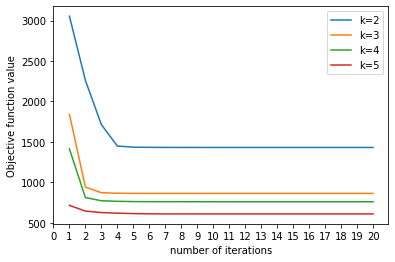

In [4]:
objective_values = []
for k in range(2,6):
    model = K_Means(k)
    model.fit(data)
    objective_values.append(model.object)
names = ['k=2','k=3','k=4','k=5']
objective_values = pd.DataFrame(np.matrix(objective_values).T, columns=names,index=range(1,21))
x = range(0,21)
xi = list(range(len(x)))
lines = objective_values.plot.line()
plt.xticks(xi,x)
plt.xlabel('number of iterations')
plt.ylabel('Objective function value')
print(lines)

1.b

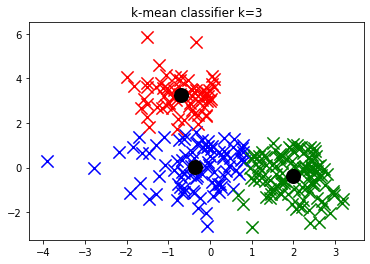

In [5]:
model3 = K_Means(3)
model3.fit(data)
model5 = K_Means(3)
model5.fit(data)
colors = ['b', 'g', 'r', 'c', 'm', 'y']
for classification in model3.classifications:
    color = colors[classification]
    for featureset in model.classifications[classification]:
        plt.scatter(featureset[0], featureset[1], marker="x", color=color, s=150, linewidths=5)
for centroid in model3.centroids:
    plt.scatter(model.centroids[centroid][0], model.centroids[centroid][1],
                marker="o", color="k", s=100, linewidths=5)
plt.title('k-mean classifier k=3')        
plt.show()

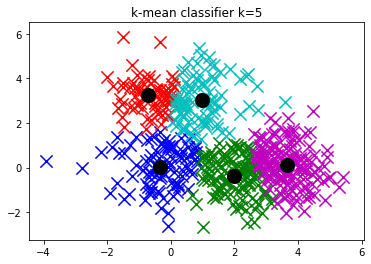

In [6]:
model5 = K_Means(5)
model5.fit(data)
model5 = K_Means(5)
model5.fit(data)
colors = ['b', 'g', 'r', 'c', 'm', 'y']
for classification in model5.classifications:
    color = colors[classification]
    for featureset in model5.classifications[classification]:
        plt.scatter(featureset[0], featureset[1], marker="x", color=color, s=150, linewidths=5)
for centroid in model5.centroids:
    plt.scatter(model5.centroids[centroid][0], model.centroids[centroid][1],
                marker="o", color="k", s=100, linewidths=5)
plt.title('k-mean classifier k=5')        
plt.show()

2.a

In [7]:
class GMM:
    def __init__(self, C, n_runs):
        self.C = C # number of Guassians/clusters
        self.n_runs = n_runs
        
    
    def get_params(self):
        return (self.mu, self.pi, self.sigma)
    

    def calculate_mean_covariance(self, X):
        d = X.shape[1]
        self.initial_means = np.zeros((self.C, d))

        self.initial_cov = np.zeros((self.C, d, d))
        for c in range(self.C):
            self.initial_cov[c,:,:] = np.cov(X.T)
            self.initial_means[c,:] = np.random.multivariate_normal(np.average(X,axis=0), np.cov(X.T),1)
        self.initial_pi = np.ones((self.C))/self.C    
        return (self.initial_means, self.initial_cov, self.initial_pi)

    def _e_step(self, X, pi, mu, sigma):
        """Performs E-step on GMM model
        Parameters:
        ------------
        X: (N x d), data points, m: no of features
        pi: (C), weights of mixture components
        mu: (C x d), mixture component means
        sigma: (C x d x d), mixture component covariance matrices
        Returns:
        ----------
        gamma: (N x C), probabilities of clusters for objects
        """
        N = X.shape[0] 
        self.gamma = np.zeros((N, self.C))

        const_c = np.zeros(self.C)
        self.mu = self.mu
        self.pi = self.pi
        self.sigma = self.sigma

        for c in range(self.C):
            # Posterior Distribution using Bayes Rule
            self.gamma[:,c] = self.pi[c] * mvn.pdf(X, self.mu[c,:], self.sigma[c],allow_singular=True)

        gamma_norm = np.sum(self.gamma, axis=1)[:,np.newaxis]
        self.gamma /= gamma_norm

        return self.gamma
    
    
    def _m_step(self, X, gamma):
        """Performs M-step of the GMM
        We need to update our priors, our means
        and our covariance matrix.
        Parameters:
        -----------
        X: (N x d), data 
        gamma: (N x C), posterior distribution of lower bound 
        Returns:
        ---------
        pi: (C)
        mu: (C x d)
        sigma: (C x d x d)
        """
        N = X.shape[0] # number of objects
        C = self.gamma.shape[1] # number of clusters
        d = X.shape[1] # dimension of each object

        # responsibilities for each gaussian
        self.pi = np.mean(self.gamma, axis = 0)

        self.mu = np.dot(self.gamma.T, X) / np.sum(self.gamma, axis = 0)[:,np.newaxis]
        
        for c in range(C):
            x = X - self.mu[c, :] # (N x d)
            
            gamma_diag = np.diag(self.gamma[:,c])
            x_mu = np.matrix(x)
            gamma_diag = np.matrix(gamma_diag)

            sigma_c = x.T * gamma_diag * x
            self.sigma[c,:,:]=(sigma_c) / np.sum(self.gamma, axis = 0)[:,np.newaxis][c]

        return self.pi, self.mu, self.sigma
    
    
    def _compute_objective_function(self, X, pi, mu, sigma):
        """Computes lower bound loss function
        
        Parameters:
        -----------
        X: (N x d), data 
        
        Returns:
        ---------
        pi: (C)
        mu: (C x d)
        sigma: (C x d x d)
        """
        N = X.shape[0]
        C = self.gamma.shape[1]
        self.objective = np.zeros((N, C))

        for c in range(C):
            dist = mvn(self.mu[c], self.sigma[c],allow_singular=True)
            self.objective[:,c] = self.gamma[:,c] * (np.log(self.pi[c]+0.00001)+dist.logpdf(X))
        self.objective = np.sum(self.objective)
        return self.objective
    
    
    
    def fit(self, X):
        """Compute the E-step and M-step and
            Calculates the lowerbound
        
        Parameters:
        -----------
        X: (N x d), data 
        
        Returns:
        ----------
        instance of GMM
        
        """
        self.object = []
        d = X.shape[1]
        self.mu, self.sigma, self.pi =  self.calculate_mean_covariance(X)
        
        try:
            for run in range(self.n_runs):  
                self.gamma  = self._e_step(X, self.mu, self.pi, self.sigma)
                self.pi, self.mu, self.sigma = self._m_step(X, self.gamma)
                objective = self._compute_objective_function(X, self.pi, self.mu, self.sigma)
                self.object.append(objective)
        
        except Exception as e:
            print(e)
            
        
        return self
    
    
    
    
    def predict(self, X):
        """Returns predicted labels using Bayes Rule to
        Calculate the posterior distribution
        
        Parameters:
        -------------
        X: ?*d numpy array
        
        Returns:
        ----------
        labels: predicted cluster based on 
        highest responsibility gamma.
        
        """
        labels = np.zeros((X.shape[0], self.C))
        
        for c in range(self.C):
            labels [:,c] = self.pi[c] * mvn.pdf(X, self.mu[c,:], self.sigma[c],allow_singular=True)
        prob  = np.max(labels,axis=1)
        return prob

In [8]:
bx_test = np.array(pd.read_csv('Prob2_Xtest.csv',header=None))
bx_train = np.array(pd.read_csv('Prob2_Xtrain.csv',header=None))
by_test = np.array(pd.read_csv('Prob2_ytest.csv',header=None))
by_train = np.array(pd.read_csv('Prob2_ytrain.csv',header=None))
bx_train_spam = bx_train[by_train.T[0]==1,:]
bx_train_email = bx_train[by_train.T[0]==0,:]
bx_test_spam =  bx_test[by_test.T[0]==1,:]
bx_test_email =  bx_test[by_test.T[0]==0,:]

In [9]:
objective_function_spam=[]
for i in range(10):
    model = GMM(3,30)
    model.fit(bx_train_spam)
    objective_function_spam.append(model.object)

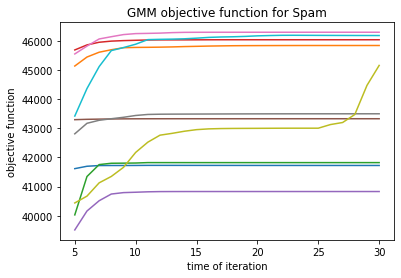

In [10]:
for i in range(10):
    plt.plot(range(5,31),objective_function_spam[i][4:30])
plt.xlabel('time of iteration')
plt.ylabel('objective function')
plt.title('GMM objective function for Spam')
plt.show()

In [11]:
objective_function_email=[]
for i in range(10):
    model = GMM(3,30)
    model.fit(bx_train_email)
    objective_function_email.append(model.object)

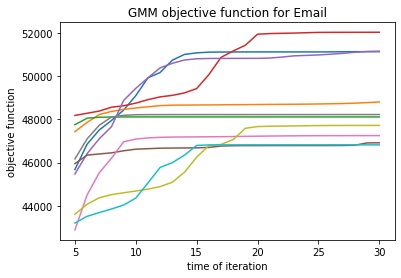

In [12]:
for i in range(10):
    plt.plot(range(5,31),objective_function_email[i][4:30])
plt.xlabel('time of iteration')
plt.ylabel('objective function')
plt.title('GMM objective function for Email')
plt.show()

2.b

In [13]:
classes = []
for i in range(1,5):
    spam_or_not = np.zeros(len(bx_test))
    model = GMM(i,30)
    model.fit(bx_train_spam)
    spam_prob=model.predict(bx_test)
    model = GMM(i,30)
    model.fit(bx_train_email)
    email_prob=model.predict(bx_test)    
    spam_check = spam_prob-email_prob
    spam_or_not[spam_check>0] = 1
    classes.append(spam_or_not)

In [14]:
names2 = ['1-GMM','2-GMM','3-GMM','4-GMM']
classes = pd.DataFrame(np.matrix(classes).T, columns=names2)
classes['true values']=by_test

In [15]:
GMM_1 = pd.crosstab(classes['1-GMM'],classes['true values'])
GMM_2 = pd.crosstab(classes['2-GMM'],classes['true values'])
GMM_3 = pd.crosstab(classes['3-GMM'],classes['true values'])
GMM_4 = pd.crosstab(classes['4-GMM'],classes['true values'])

In [16]:
print(GMM_1)
print('Accuracy of 1-GMM',sum(classes['2-GMM']==classes['true values'])/len(bx_test))
print(GMM_2)
print('Accuracy of 2-GMM',sum(classes['2-GMM']==classes['true values'])/len(bx_test))
print(GMM_3)
print('Accuracy of 3-GMM',sum(classes['3-GMM']==classes['true values'])/len(bx_test))
print(GMM_4)
print('Accuracy of 4-GMM',sum(classes['4-GMM']==classes['true values'])/len(bx_test))

true values    0    1
1-GMM                
0.0          180    6
1.0           98  176
Accuracy of 1-GMM 0.7891304347826087
true values    0    1
2-GMM                
0.0          197   16
1.0           81  166
Accuracy of 2-GMM 0.7891304347826087
true values    0    1
3-GMM                
0.0          197    6
1.0           81  176
Accuracy of 3-GMM 0.8108695652173913
true values    0    1
4-GMM                
0.0          201   10
1.0           77  172
Accuracy of 4-GMM 0.8108695652173913


3.a

In [152]:
def RMSE(preds, truth):
    return np.sqrt(np.mean(np.square(preds-truth)))
class PMF:
    # initialize some paprameters
    def __init__(self, M, lambda_= 1, d=10, iters=100, sigma=0.5):
        self.lambda_ = lambda_
        self.M = M
        self.iterations = iters
        self.I = copy.deepcopy(self.M)
        self.I[self.I != 0] = 1
        self.d = d
        self.U = np.random.randn(np.size(M, 0), d)  # N1 x D
        self.V = np.random.randn(np.size(M, 1), d)  # N2 x D
        self.N1 = len(self.U)
        self.N2 = len(self.V)
        self.sigma = sigma
        
    def objective_calculate(self):
        # the objective function of the model
        objective = -np.sum(self.I*(self.M-np.dot(self.U, self.V.T))**2)/self.sigma**2 - self.lambda_/2*np.sum(np.square(self.U)) - self.lambda_/2*np.sum(np.square(self.V))
        return objective
    def predict(self, data):
        index_data = np.array([[int(ele[0]), int(ele[1])] for ele in data], dtype=int)
        u_features = self.U.take(index_data.take(0, axis=1), axis=0)
        v_features = self.V.take(index_data.take(1, axis=1), axis=0)
        preds_value_array = np.sum(u_features*v_features, 1)
        return preds_value_array

    def train(self, train_data=None, vali_data=None):
        train_objective_list = []
        vali_rmse_list = []
        last_vali_rmse = None
        
        for it in range(self.iterations):
            for i in range(self.N1):
                self.U[i] = inv(self.lambda_*self.sigma**2*np.identity(self.d)+(self.V*self.I.T[:,i][:, np.newaxis]).T.dot(self.V*self.I.T[:,i][:, np.newaxis])).dot(self.M[i].dot(self.V))
            for i in range(self.N2):
                self.V[i] = inv(self.lambda_*self.sigma**2*np.identity(self.d)+(self.U*self.I.T[i][:, np.newaxis]).T.dot(self.U*self.I.T[i][:, np.newaxis])).dot(M[:,i].dot(self.U))

            # training evaluation
            train_objective = self.objective_calculate()
            train_objective_list.append(train_objective)

            vali_preds = self.predict(vali_data)
            vali_rmse = RMSE(vali_data[:,2], vali_preds)
            vali_rmse_list.append(vali_rmse)

        return self.U, self.V, train_objective_list, vali_rmse_list

In [225]:
data_3 = np.array(pd.read_csv('Prob3_ratings.csv',header=None))
data_3_test = np.array(pd.read_csv('Prob3_ratings_test.csv',header=None))
num_user = int(max(np.amax(data_3[:, 0]), np.amax(data_3_test[:, 0]))) + 1 
num_item = int(max(np.amax(data_3[:, 1]), np.amax(data_3_test[:, 1]))) + 1 
M = np.zeros([num_user, num_item])
for ele in data_3:
    M[int(ele[0]), int(ele[1])] = float(ele[2])

In [181]:
validation_value = []
for i in range(10):
    model = PMF(M,lambda_= 1, d=10, iters=100, sigma=0.5)
    validation_value.append(model.train(vali_data=data_3_test))

In [206]:
likelihood = []
V_posteri = []
RMSE_OBJ=[]
for i in range(10):
    likelihood.append(validation_value[i][2])
    V_posteri.append(validation_value[i][1])
    RMSE_OBJ.append(np.array(validation_value[i][2:4])[:,-1])

AxesSubplot(0.125,0.125;0.775x0.755)


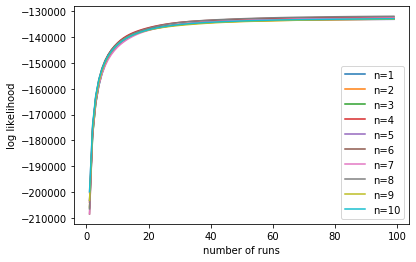

In [207]:
names_4 = ['n=1','n=2','n=3','n=4','n=5','n=6','n=7','n=8','n=9','n=10']
likelihood = pd.DataFrame(np.matrix(likelihood).T, columns=names_4)
lines_4 = likelihood[1:100].plot.line()
plt.xlabel('number of runs')
plt.ylabel('log likelihood')
print(lines)

In [211]:
RMSE_OBJ = pd.DataFrame(RMSE_OBJ,columns=['objective function value','RMSE'])
RMSE_OBJ['Number of runs'] = range(1,11)
RMSE_OBJ.sort_values(by ='objective function value',ascending=False )

,objective function value,RMSE,Number of runs
7,-176878.983313,1.102460,8
3,-177138.913753,1.092742,4
6,-177556.430934,1.105014,7
5,-177705.444112,1.115969,6
0,-177767.634088,1.127506,1
9,-177842.167361,1.143674,10
2,-177862.975213,1.102247,3
1,-177973.273402,1.125172,2
8,-178019.036220,1.127271,9
4,-178080.199244,1.152909,5


3.b

In [174]:
values = np.array(validation_value[1][2:4])[:,-1]
pd.DataFrame(values).T

,0,1
0,-176878.595698,1.134523


In [282]:
movie_names = pd.read_table('Prob3_movies.txt',header=None)
movie_names = movie_names[0].tolist()
Best_V=V_posteri[7][1:]
Star_Wars = Best_V[movie_names.index('Star Wars (1977)')]
My_Fair_Lady = Best_V[movie_names.index('My Fair Lady (1964)')]
Goodfellas = Best_V[movie_names.index('GoodFellas (1990)')]
Star_Wars_distence =[np.linalg.norm(Best_V[i]-Star_Wars)**2 for i in range(len(Best_V))]
My_Fair_Lady_distance =[np.linalg.norm(Best_V[i]-My_Fair_Lady)**2 for i in range(len(Best_V))]
Goodfellas_distance =[np.linalg.norm(Best_V[i]-Goodfellas)**2 for i in range(len(Best_V))]
SW = pd.DataFrame(Star_Wars_distence,columns=['distance'])
SW['Movie Name']=movie_names
SW.sort_values(by ='distance')[1:11]

,distance,Movie Name
171,0.089833,"Empire Strikes Back, The (1980)"
180,0.387243,Return of the Jedi (1983)
173,0.410919,Raiders of the Lost Ark (1981)
172,0.735332,"Princess Bride, The (1987)"
185,0.738842,"Blues Brothers, The (1980)"
428,0.784949,"Day the Earth Stood Still, The (1951)"
1268,0.881418,Love in the Afternoon (1957)
0,0.913472,Toy Story (1995)
227,0.914545,Star Trek: The Wrath of Khan (1982)
209,0.915582,Indiana Jones and the Last Crusade (1989)


In [283]:
MFL = pd.DataFrame(My_Fair_Lady_distance,columns=['distance'])
MFL['Movie Name']=movie_names
MFL.sort_values(by ='distance')[1:11]

,distance,Movie Name
418,0.377320,Mary Poppins (1964)
142,0.585792,"Sound of Music, The (1965)"
1196,0.755791,"Family Thing, A (1996)"
416,0.896260,"Parent Trap, The (1961)"
601,0.912381,"American in Paris, An (1951)"
485,0.918382,Sabrina (1954)
603,0.923976,It Happened One Night (1934)
784,0.981876,Only You (1994)
415,0.983228,Old Yeller (1957)
7,0.996101,Babe (1995)


In [284]:
GF = pd.DataFrame(Goodfellas_distance,columns=['distance'])
GF['Movie Name']=movie_names
GF.sort_values(by ='distance')[1:11]

,distance,Movie Name
187,0.477463,Full Metal Jacket (1987)
692,0.480336,Casino (1995)
176,0.513849,"Good, The Bad and The Ugly, The (1966)"
186,0.558341,"Godfather: Part II, The (1974)"
503,0.585183,Bonnie and Clyde (1967)
179,0.656491,Apocalypse Now (1979)
1069,0.758058,Living in Oblivion (1995)
645,0.760141,Once Upon a Time in the West (1969)
126,0.775059,"Godfather, The (1972)"
134,0.815253,2001: A Space Odyssey (1968)
